In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner

In [2]:
chain = np.loadtxt('../dynamics_chains/kcwi_dynamics_chain_jampy_ifu_constant_True_powerlaw.txt')

In [3]:
chain.shape

(24000, 8)

In [15]:
from kinematics_likelihood import KinematicLikelihood


likelihood_class = KinematicLikelihood(lens_model_type='powerlaw',
                                       software='jampy',
                                       anisotropy_model='constant',
                                       aperture='ifu',
                                       snr_per_bin=15,
                                       is_spherical=True,
                                       mpi=False
                                       )

walker_ratio = 6
num_steps = 500
num_param = 8 
num_walker = num_param * walker_ratio

init_lens_params = np.random.multivariate_normal(
    likelihood_class.lens_model_posterior_mean,
    cov=likelihood_class.lens_model_posterior_covariance,
    size=num_walker)

init_pos = np.concatenate((
    init_lens_params,
    # lambda, ani_param, inclination (deg)
    np.random.normal(loc=[1, 1, 90], scale=[0.1, 0.05, 5],
                     size=(num_walker, 3))
), axis=1)

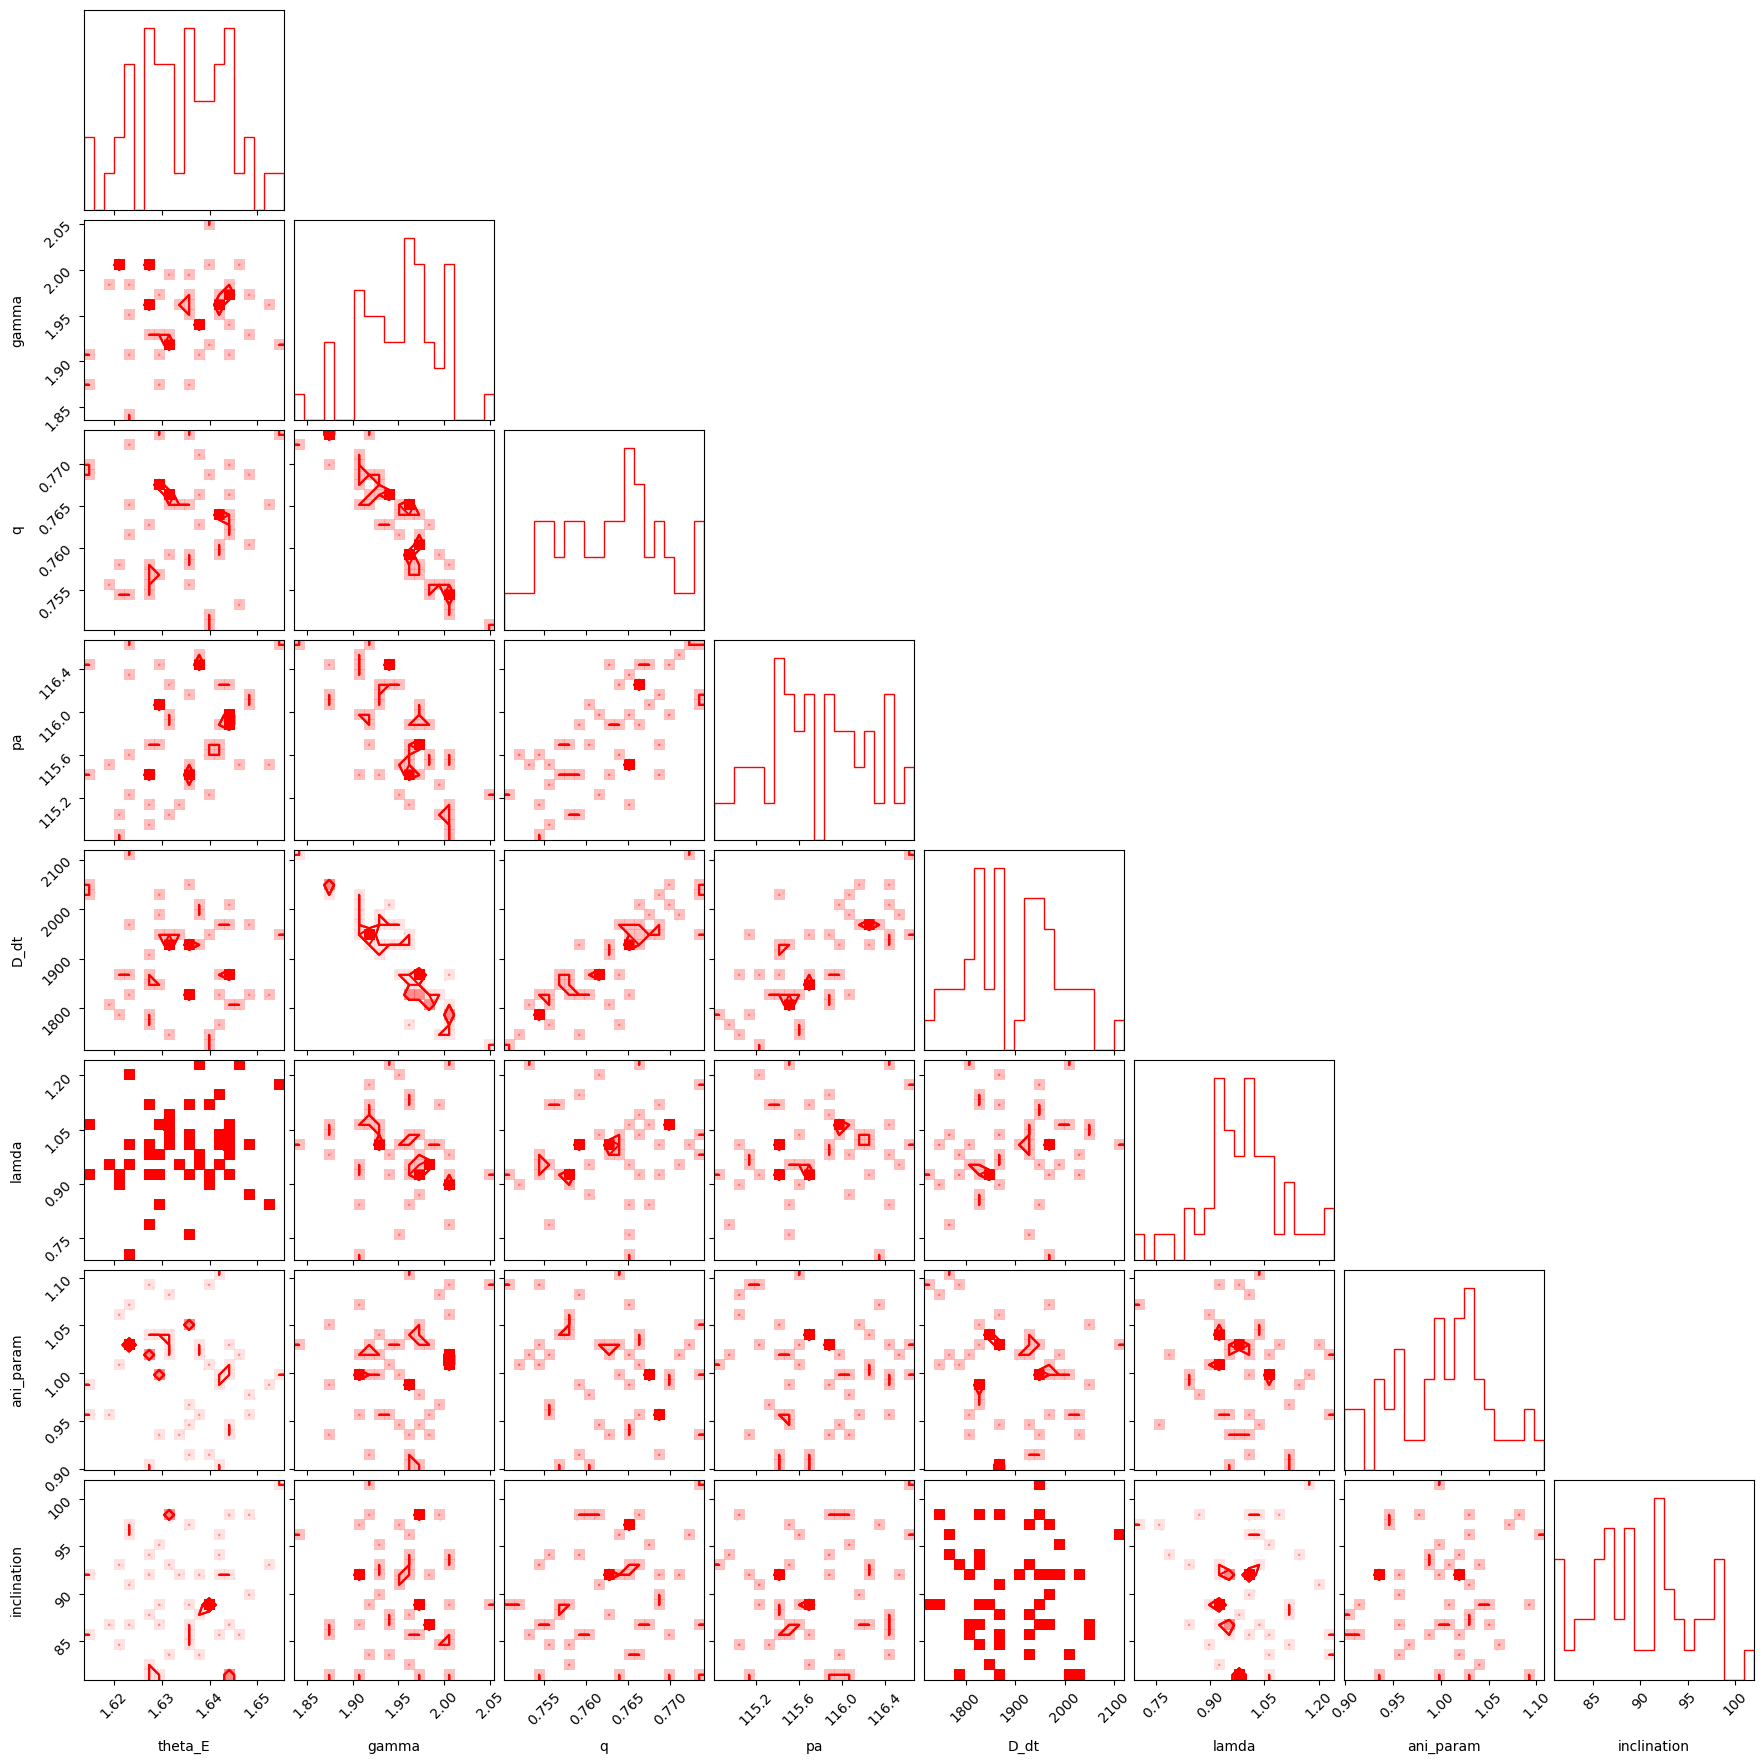

In [21]:
labels = ['theta_E', 'gamma', 'q', 'pa', 'D_dt', 'lamda', 'ani_param', 'inclination']

# fig = corner.corner(chain[-10000:, :], 
#               labels=labels);

corner.corner(init_pos, color='red',
              labels=labels
             );

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_85016/3880108712.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 500, N_walkers: 48, N_params: 8
theta_E 1.6678 ± 0.0151
gamma 2.4991 ± 0.0012
q 0.6908 ± 0.0037
pa 112.9542 ± 0.4490
D_dt 1.0702 ± 0.0573
lamda 2.4367 ± 0.3924
ani_param -2.4239 ± 13.8303
inclination 86.9354 ± 19.0467


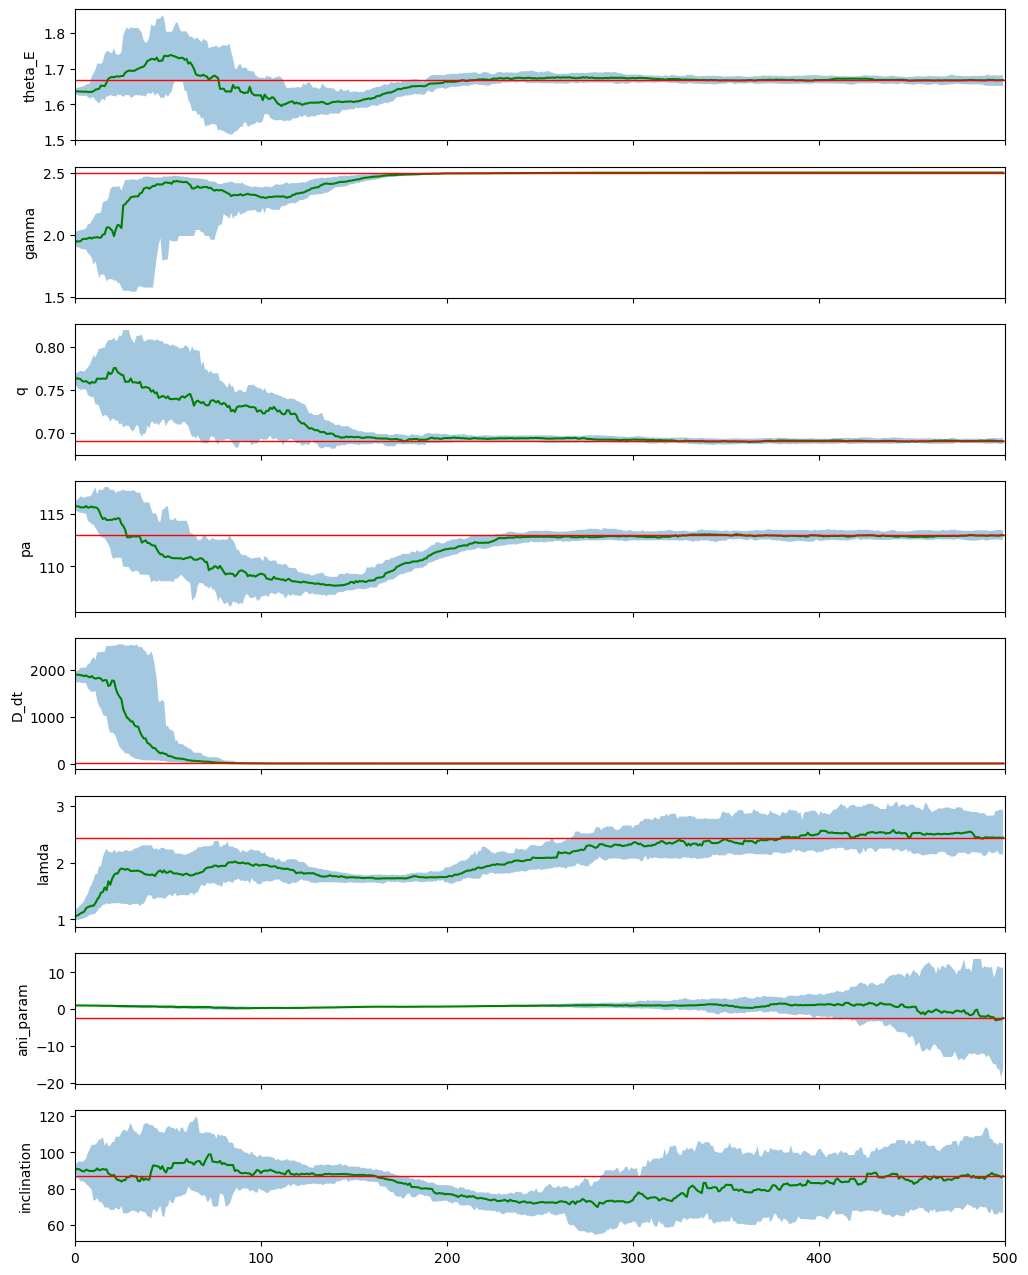

In [22]:
samples_mcmc = chain
param_mcmc = labels

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = 6 * n_params
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print('N_step: {}, N_walkers: {}, N_params: {}'.format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in np.arange(n_params):
        samples = samples_mcmc[:, i].T
        chain[:,:,i] = samples.reshape((n_step, n_walkers)).T

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in np.arange(n_params):
        for j in np.arange(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [median_pos[0][last-1], (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                    median_pos[1][last-1], (q84_pos[1][last-1]-q16_pos[1][last-1])/2]

    for i in range(n_params):
        print(param_mcmc[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last-1], (q84_pos[i][last-1]-q16_pos[i][last-1])/2))

        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4)
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12., 2*len(param_mcmc)))
        plt.show()